In [1]:
import sys
sys.path.append("../deep-learning-dna")
from __future__ import absolute_import, division, print_function, unicode_literals
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
import wandb
from lmdbm import Lmdb
import settransformer as st
from common.models import CustomModel
from common.models import dnabert
import os, glob
import tf_utils as tfu

In [2]:
strategy = tfu.strategy.gpu(1)

2022-07-12 12:10:46.564040: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-12 12:10:47.205316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9621 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


In [3]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
class ContiguousMask(keras.layers.Layer):
    """
    Mask out contiguous blocks of input tokens (provided as integers)
    """
    def __init__(self, mask_ratio, **kwargs):
        super().__init__(**kwargs)
        self.mask_ratio = tf.Variable(
            mask_ratio, trainable=False, dtype=tf.float32, name="Mask_Ratio")

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        mask_len = tf.cast(tf.cast(seq_len, dtype=tf.float32) * self.mask_ratio, dtype=tf.int32)

        # Pick random mask offsets
        mask_offsets = tf.random.uniform((batch_size,), minval=0, maxval=(seq_len - mask_len + 1), dtype=tf.int32)

        # Construct and the mask
        left = tf.sequence_mask(mask_offsets, seq_len)
        right = tf.logical_not(tf.sequence_mask(mask_offsets + mask_len, seq_len))
        mask = tf.cast(tf.logical_or(left, right), dtype=inputs.dtype)

        # Return the masked inputs, and the mask
        return mask * inputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "mask_ratio": self.mask_ratio.numpy()
        })
        return config

class InvertMask(keras.layers.Layer):
    """
    Invert the current mask. Useful for DNABERT models where we *want* to pay attention to the
    masked elements.
    """
    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        return tf.logical_not(mask)

    def call(self, inputs):
        # tf.print(inputs)
        # tf.print(inputs + 0)
        return inputs + 0 # hacky, but without modification

In [5]:
class SetMask(keras.layers.Layer):
    def __init__(self, mask_ratio, **kwargs):
        super().__init__(**kwargs)
        self.mask_ratio = tf.Variable(mask_ratio, trainable=False, dtype=tf.float32, name='Mask_Ratio')
        
    def call(self, inputs, mask=None):
        mask = self.compute_mask(inputs, mask)
        return tf.cast(mask, dtype=tf.float32) * inputs
    
    def compute_mask(self, inputs, mask):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        embed_dim = tf.shape(inputs)[2]
        mask_len = tf.cast(tf.cast(seq_len, dtype=tf.float32) * self.mask_ratio, dtype=tf.int32)
        
        random = tf.random.uniform((batch_size, seq_len), 0, 1)
        values, indices = tf.math.top_k(random, mask_len)
        batch_indices = tf.reshape(tf.repeat(tf.range(batch_size), mask_len), (-1,1))
        embedding_indices = tf.reshape(indices, (-1, 1))
        indices = tf.concat((batch_indices, embedding_indices), axis=1)
        mask = tf.ones((batch_size, seq_len))
        mask = tf.tensor_scatter_nd_update(mask, indices, tf.zeros((batch_size * mask_len)))
        mask = tf.tile(tf.expand_dims(mask, axis=2), (1, 1, embed_dim))
        return tf.cast(mask, dtype=tf.bool)

In [6]:
class SetClassToken(keras.layers.Layer):
    def __init__(self, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.class_token = self.add_weight(shape=(1, 1, embedding_dim), initializer='random_normal',
                                           trainable=True, name='Class_token')
    
    def compute_mask(self, inputs, mask):
        batch_size = tf.shape(inputs)[0]
        token_mask = tf.ones((batch_size, 1, self.embedding_dim), dtype=tf.bool)
        return tf.concat((token_mask, mask), axis=1)
    
    def call(self, inputs, mask=None):
        batch_size = tf.shape(inputs)[0]
        tokens = tf.tile(self.class_token, (batch_size, 1, 1))
        return tf.concat((tokens, inputs), axis=1)

In [7]:
class SubBatchModel(CustomModel):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def call(self, inputs, training=None):
        return self.model(inputs, training=training)
    
    def compute_mask(self, inputs, mask):
        return mask

In [8]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, samples, batch_size, subsample_size, num_batches, rng=None):
        super().__init__()
        self.batch_size = batch_size
        self.subsample_size = subsample_size
        self.samples = self.open_samples(samples)
        self.num_batches = num_batches
        self.rng = rng if rng is not None else np.random.default_rng()
        
    def __getitem__(self, i):
        batch = []
        sample_indices = self.rng.integers(len(self.samples), size=self.batch_size)
        for si in sample_indices:
            indices = self.rng.choice(len(self.samples[si]), self.subsample_size, replace=False)
            pre_embeddings = []
            for i in indices:
                pre_embeddings.append(np.asarray(np.frombuffer(self.samples[si][str(i)], dtype=np.float32)))
            batch.append(pre_embeddings)
            
        return np.array(batch), np.array(batch)
    
    def __len__(self):
        return self.num_batches
    
    def open_samples(self, samples):
        samples_final = []
        for sample in samples:
            store = Lmdb.open(sample, lock=False)
            if len(store) < self.subsample_size:
                print(f"Warning: Sample '{sample}' only contains {len(store)} sequences. This sample will not be included.")
                store.close()
                continue
            samples_final.append(store)
        return samples_final

In [9]:
samples_train = []
path = './pre_embedded_samples/train'
for filename in glob.glob(os.path.join(path, '*.db')):
    samples_train.append(filename)
samples_train

['./pre_embedded_samples/train/WS-MR-Jul2015_S26_L001_R1_001.db',
 './pre_embedded_samples/train/Wes9-5-AG_S10_L001_R1_001.db',
 './pre_embedded_samples/train/Wesley018-HN-072820_S157_L001_R1_001.db',
 './pre_embedded_samples/train/WS-WH-Oct2016_S87_L001_R1_001.db',
 './pre_embedded_samples/train/Wesley002-MR-051220_S141_L001_R1_001.db',
 './pre_embedded_samples/train/WS-HF-Jul2015_S42_L001_R1_001.db',
 './pre_embedded_samples/train/WS-SB-Oct2016_S63_L001_R1_001.db',
 './pre_embedded_samples/train/WS-WH-Sep2015_S59_L001_R1_001.db',
 './pre_embedded_samples/train/WS-MR-Sep2015_S67_L001_R1_001.db',
 './pre_embedded_samples/train/WS-AG-Jul2015_S3_L001_R1_001.db',
 './pre_embedded_samples/train/Wes53-10-SOY_S54_L001_R1_001.db',
 './pre_embedded_samples/train/WS-MR-Jul2016_S54_L001_R1_001.db',
 './pre_embedded_samples/train/Wes49-10-SB_S50_L001_R1_001.db',
 './pre_embedded_samples/train/WS-HF-May2015_S9_L001_R1_001.db',
 './pre_embedded_samples/train/Wes29-8-SB_S30_L001_R1_001.db',
 './pre_

In [10]:
samples_val = []
path = './pre_embedded_samples/validation'
for filename in glob.glob(os.path.join(path, '*.db')):
    samples_val.append(filename)
samples_val

['./pre_embedded_samples/validation/WS-MR-Jul2015_S26_L001_R1_001.db',
 './pre_embedded_samples/validation/Wes9-5-AG_S10_L001_R1_001.db',
 './pre_embedded_samples/validation/Wesley018-HN-072820_S157_L001_R1_001.db',
 './pre_embedded_samples/validation/WS-WH-Oct2016_S87_L001_R1_001.db',
 './pre_embedded_samples/validation/Wesley002-MR-051220_S141_L001_R1_001.db',
 './pre_embedded_samples/validation/WS-HF-Jul2015_S42_L001_R1_001.db',
 './pre_embedded_samples/validation/WS-SB-Oct2016_S63_L001_R1_001.db',
 './pre_embedded_samples/validation/WS-WH-Sep2015_S59_L001_R1_001.db',
 './pre_embedded_samples/validation/WS-MR-Sep2015_S67_L001_R1_001.db',
 './pre_embedded_samples/validation/WS-AG-Jul2015_S3_L001_R1_001.db',
 './pre_embedded_samples/validation/Wes53-10-SOY_S54_L001_R1_001.db',
 './pre_embedded_samples/validation/WS-MR-Jul2016_S54_L001_R1_001.db',
 './pre_embedded_samples/validation/Wes49-10-SB_S50_L001_R1_001.db',
 './pre_embedded_samples/validation/WS-HF-May2015_S9_L001_R1_001.db',
 

In [11]:
seq_gen_train = DataGenerator(samples_train, 32, 1000, 20)
seq_gen_val = DataGenerator(samples_val, 32, 1000, 10)

In [12]:
input_layer = keras.layers.Input((1000, 8))
masking_layer = SetMask(mask_ratio=0.15)
masked = masking_layer(input_layer)
class_tokens = SetClassToken(8)
tokens_added = class_tokens(masked)
for i in range(8):
    ISAB = st.ISAB(8, 2, 30)
    tokens_added = ISAB(tokens_added)
inverted_mask = InvertMask()(tokens_added)
output = keras.layers.Lambda(lambda x: x[:, 1:, :])(inverted_mask)
class_token_embeddings = keras.layers.Lambda(lambda x: x[:, 0, :])(inverted_mask)

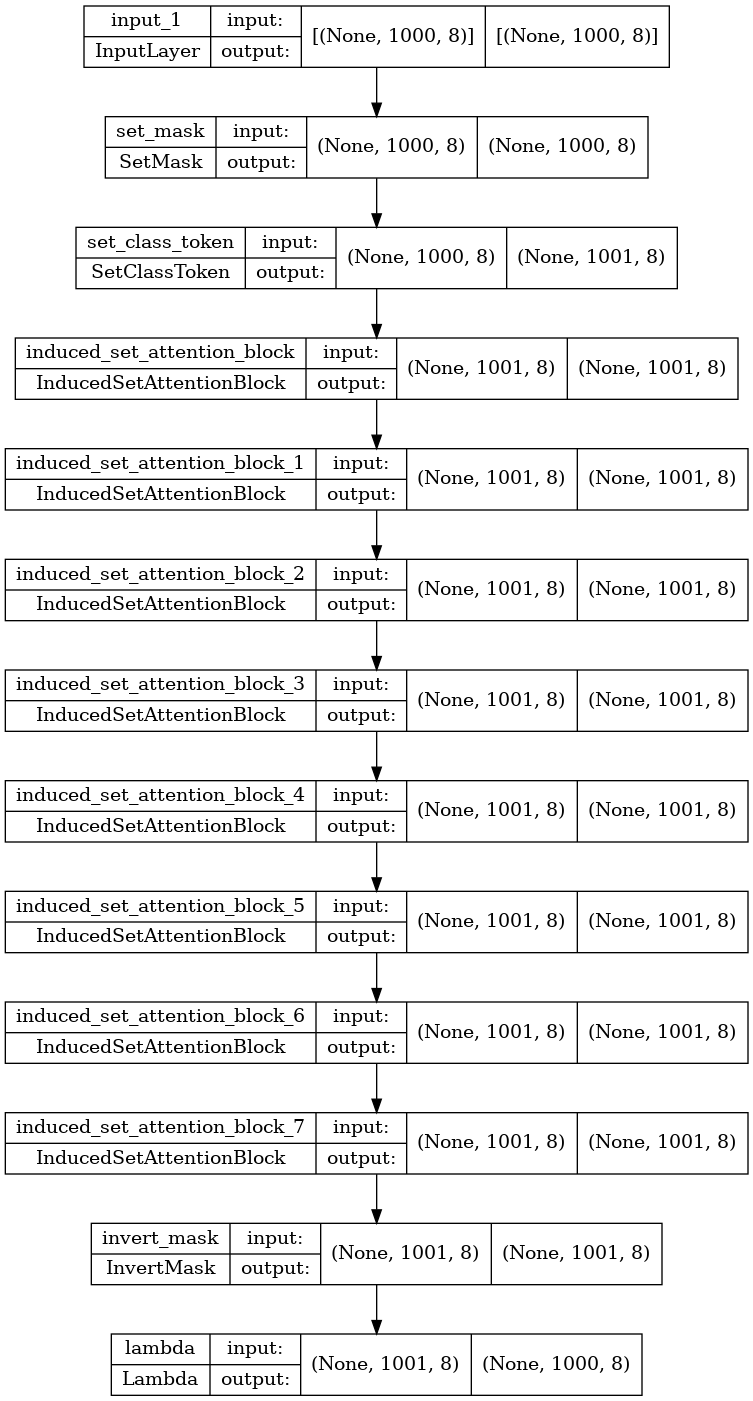

In [13]:
setbert = SubBatchModel(keras.Model(input_layer, output))
keras.utils.plot_model(setbert.model,show_shapes=True,expand_nested=True)

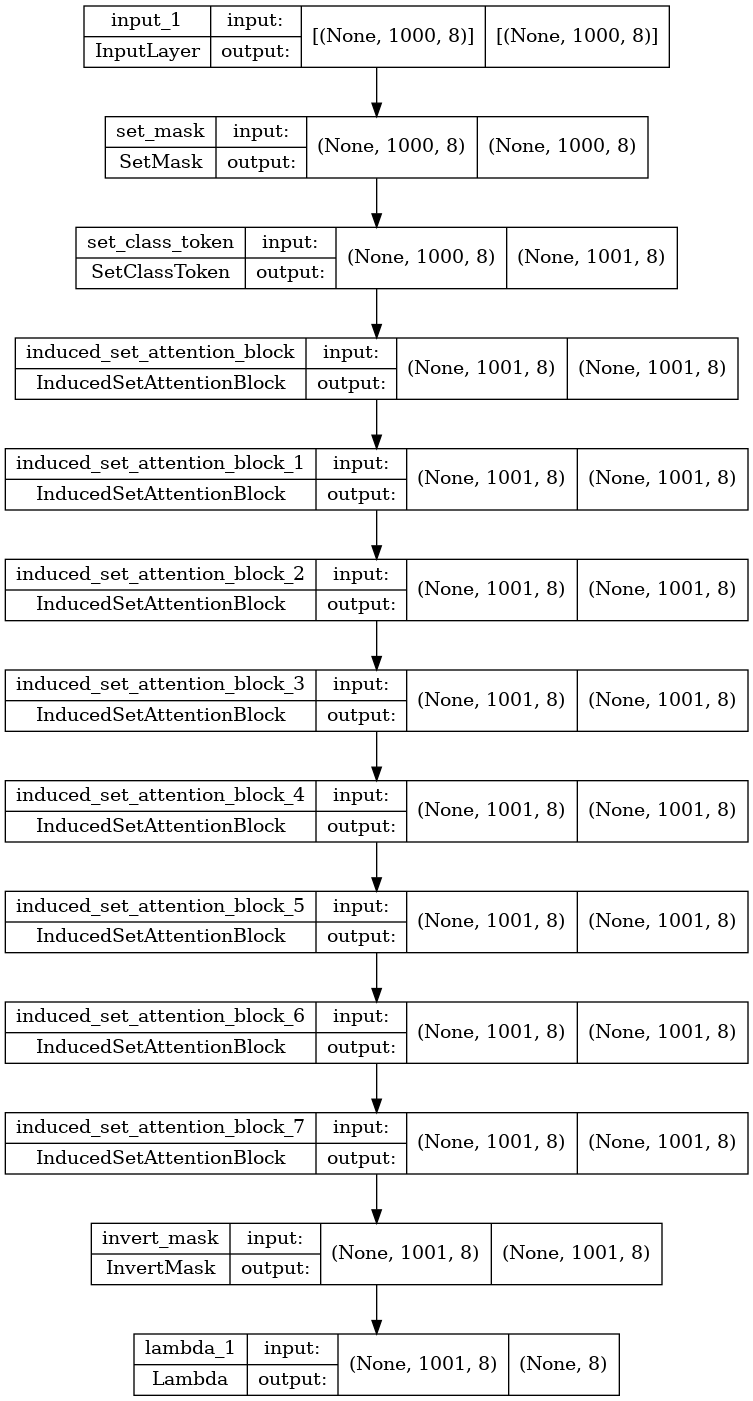

In [14]:
setbert_tokens = SubBatchModel(keras.Model(input_layer, class_token_embeddings))
keras.utils.plot_model(setbert_tokens.model,show_shapes=True,expand_nested=True)

In [15]:
setbert_tokens.predict(seq_gen_train[0][0], batch_size=8)

array([[-0.08827129,  0.9039582 ,  0.5787461 ,  1.1382941 ,  0.64114785,
        -2.1435015 , -0.5780175 , -0.4523557 ],
       [ 0.09875436,  0.61609185,  0.9237591 ,  0.68880445, -0.04689038,
        -2.4375784 ,  0.48261422, -0.32555544],
       [-0.10488462,  0.8969437 ,  0.59648657,  1.124122  ,  0.5941374 ,
        -2.1885319 , -0.4785668 , -0.43970653],
       [-0.1370301 ,  0.9006513 ,  0.50896776,  1.1366091 ,  0.755476  ,
        -2.1116621 , -0.65848714, -0.39452475],
       [ 0.04950154,  0.58621967,  0.9506959 ,  0.64616746, -0.07455954,
        -2.4427507 ,  0.5419941 , -0.25726822],
       [-0.10663822,  0.8957304 ,  0.5738512 ,  1.1351167 ,  0.6256895 ,
        -2.173162  , -0.51110125, -0.43948624],
       [ 0.06399506,  0.60573554,  0.92729306,  0.681736  , -0.04798529,
        -2.4455905 ,  0.493451  , -0.2786348 ],
       [ 0.03635497,  0.58842206,  0.9433003 ,  0.69066733, -0.10877854,
        -2.4351492 ,  0.53191566, -0.2467323 ],
       [-0.08146732,  0.9066211 

In [16]:
setbert_tokens.predict(seq_gen_val[0][0], batch_size=8)

array([[ 0.35728925, -0.07586622,  1.0681411 , -1.5764014 , -0.7785421 ,
        -0.9725369 ,  1.5941794 ,  0.38373658],
       [ 1.1175013 ,  0.9242667 ,  1.061567  , -0.42739683, -1.9716425 ,
        -0.68706334,  0.32883477, -0.34606707],
       [ 1.1135883 ,  0.9166869 ,  1.0729487 , -0.4254399 , -1.9658157 ,
        -0.7064172 ,  0.33182266, -0.33737397],
       [ 0.10623508, -0.36599308,  0.87017757, -1.2335238 , -0.6567963 ,
        -1.1985425 ,  1.8034655 ,  0.6749775 ],
       [ 1.1356539 ,  0.92233074,  1.0056055 , -0.43009388, -2.0117068 ,
        -0.60839754,  0.34413657, -0.35752848],
       [ 1.1367625 ,  0.9110369 ,  1.0261552 , -0.43807632, -1.9985353 ,
        -0.63361156,  0.34256035, -0.34629175],
       [-0.01830274, -0.4692406 ,  0.7908106 , -1.0416565 , -0.62820363,
        -1.2724555 ,  1.8547689 ,  0.78427917],
       [ 1.1401684 ,  0.9076295 ,  1.0416665 , -0.41799313, -1.986624  ,
        -0.6622441 ,  0.3285034 , -0.35110682],
       [ 1.0960473 ,  0.8988012 

In [17]:
setbert.compile(optimizer=keras.optimizers.Nadam(1e-4), loss=tf.keras.losses.LogCosh())

In [19]:
history = setbert.fit(seq_gen_train, epochs=50, subbatch_size=8, validation_data=seq_gen_val)

Epoch 1/50
20/20 [==============================] - 126s 5s/step - loss: 3.4797 - val_loss: 1.6941
Epoch 2/50
20/20 [==============================] - 11s 520ms/step - loss: 3.4435 - val_loss: 1.6979
Epoch 3/50
20/20 [==============================] - 5s 256ms/step - loss: 3.4290 - val_loss: 1.6667
Epoch 4/50
20/20 [==============================] - 5s 251ms/step - loss: 3.4242 - val_loss: 1.6525
Epoch 5/50
20/20 [==============================] - 5s 255ms/step - loss: 3.4057 - val_loss: 1.6206
Epoch 6/50
20/20 [==============================] - 5s 246ms/step - loss: 3.4021 - val_loss: 1.5845
Epoch 7/50
20/20 [==============================] - 5s 241ms/step - loss: 3.3941 - val_loss: 1.5673
Epoch 8/50
20/20 [==============================] - 5s 244ms/step - loss: 3.3924 - val_loss: 1.5469
Epoch 9/50
20/20 [==============================] - 5s 244ms/step - loss: 3.3865 - val_loss: 1.5475
Epoch 10/50
20/20 [==============================] - 5s 248ms/step - loss: 3.3829 - val_loss: 1.5242

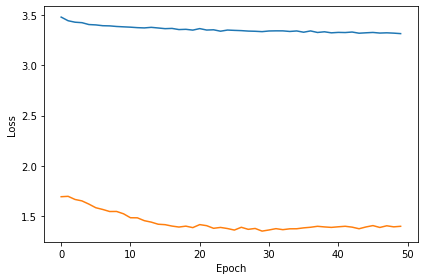

In [20]:
plt.figure(1) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')  
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

In [21]:
samples_test = []
path = './pre_embedded_samples/test'
for filename in glob.glob(os.path.join(path, '*.db')):
    samples_test.append(filename)
samples_test

['./pre_embedded_samples/test/WS-MR-Jul2015_S26_L001_R1_001.db',
 './pre_embedded_samples/test/Wes9-5-AG_S10_L001_R1_001.db',
 './pre_embedded_samples/test/Wesley018-HN-072820_S157_L001_R1_001.db',
 './pre_embedded_samples/test/WS-WH-Oct2016_S87_L001_R1_001.db',
 './pre_embedded_samples/test/Wesley002-MR-051220_S141_L001_R1_001.db',
 './pre_embedded_samples/test/WS-HF-Jul2015_S42_L001_R1_001.db',
 './pre_embedded_samples/test/WS-SB-Oct2016_S63_L001_R1_001.db',
 './pre_embedded_samples/test/WS-WH-Sep2015_S59_L001_R1_001.db',
 './pre_embedded_samples/test/WS-MR-Sep2015_S67_L001_R1_001.db',
 './pre_embedded_samples/test/WS-AG-Jul2015_S3_L001_R1_001.db',
 './pre_embedded_samples/test/Wes53-10-SOY_S54_L001_R1_001.db',
 './pre_embedded_samples/test/WS-MR-Jul2016_S54_L001_R1_001.db',
 './pre_embedded_samples/test/Wes49-10-SB_S50_L001_R1_001.db',
 './pre_embedded_samples/test/WS-HF-May2015_S9_L001_R1_001.db',
 './pre_embedded_samples/test/Wes29-8-SB_S30_L001_R1_001.db',
 './pre_embedded_sample

In [22]:
seq_gen_collection = []
labels = []
for sample in samples_test:
    seq_gen = DataGenerator([sample], 32, 1000, 20)
    if len(seq_gen.samples) > 0:
        seq_gen_collection.append(seq_gen[0][0])
        labels.append(sample)
seq_gen_collection = seq_gen_collection[:10]

In [23]:
class_tokens = []
for seq_gen in seq_gen_collection:
    class_tokens.append(setbert_tokens.predict(seq_gen))

In [24]:
class_tokens = np.concatenate(class_tokens)

In [25]:
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist

In [26]:
dist_mat = cdist(class_tokens, class_tokens)
dist_mat

array([[0.        , 0.01426848, 0.05193064, ..., 3.57602955, 3.64022248,
        3.63502532],
       [0.01426848, 0.        , 0.04862161, ..., 3.57075465, 3.63509615,
        3.62987937],
       [0.05193064, 0.04862161, 0.        , ..., 3.54812232, 3.61283433,
        3.60751592],
       ...,
       [3.57602955, 3.57075465, 3.54812232, ..., 0.        , 0.09437956,
        0.08443509],
       [3.64022248, 3.63509615, 3.61283433, ..., 0.09437956, 0.        ,
        0.01366815],
       [3.63502532, 3.62987937, 3.60751592, ..., 0.08443509, 0.01366815,
        0.        ]])

In [27]:
dist_mat.shape

(320, 320)

In [28]:
mds = MDS(metric=True, dissimilarity='precomputed', n_jobs=10)

In [29]:
points = mds.fit_transform(dist_mat)
points.shape

(320, 2)

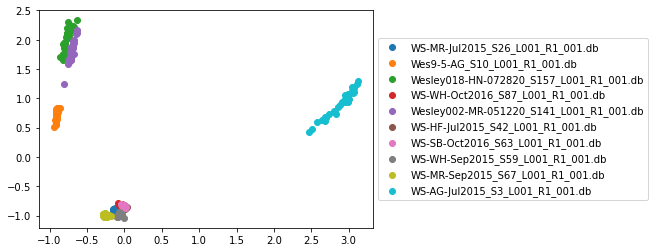

In [30]:
for cluster in points.reshape(len(seq_gen_collection), 32, 2):
    plt.scatter(*cluster.T)
plt.legend([os.path.basename(s) for s in labels], loc='center left', bbox_to_anchor=(1., 0.5))

In [31]:
from common import metrics

In [32]:
chamfer_dist = metrics.chamfer_distance_matrix(np.concatenate(seq_gen_collection), p=1, workers=10,
                                fn=metrics.chamfer_distance)

In [33]:
chamfer_dist.shape

(320, 320)

In [34]:
chamfer_dist

array([[ 0.        ,  1.55467999,  1.59111714, ..., 21.22057152,
        21.5463562 , 22.40540504],
       [ 1.55467999,  0.        ,  1.60499477, ..., 21.14241219,
        21.51063347, 22.34567261],
       [ 1.59111714,  1.60499477,  0.        , ..., 21.26265907,
        21.63936615, 22.43431854],
       ...,
       [21.22057152, 21.14241219, 21.26265907, ...,  0.        ,
         5.65725327,  5.70082092],
       [21.5463562 , 21.51063347, 21.63936615, ...,  5.65725327,
         0.        ,  5.6325388 ],
       [22.40540504, 22.34567261, 22.43431854, ...,  5.70082092,
         5.6325388 ,  0.        ]])

In [35]:
mds_chamfer = MDS(metric=True, dissimilarity='precomputed', n_jobs=10)

In [36]:
chamfer_points = mds_chamfer.fit_transform(chamfer_dist)

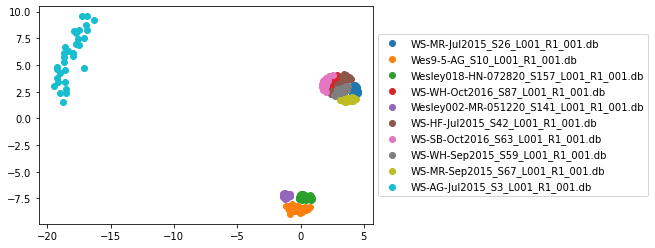

In [37]:
for cluster in chamfer_points.reshape(len(seq_gen_collection), 32, 2):
    plt.scatter(*cluster.T)
plt.legend([os.path.basename(s) for s in labels], loc='center left', bbox_to_anchor=(1., 0.5))

In [38]:
from sklearn.cluster import KMeans

In [39]:
kmeans = KMeans(n_clusters=10)
labels = kmeans.fit_predict(class_tokens)
labels

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7,
       4, 7, 7, 4, 4, 7, 4, 4, 7, 7, 4, 7, 4, 7, 7, 4, 7, 4, 7, 4, 4, 4,
       4, 4, 4, 7, 4, 7, 4, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 4, 1, 1,
       1, 1, 7, 7, 4, 7, 1, 1, 7, 1, 1, 1, 1, 7, 7, 4, 7, 1, 7, 1, 1, 7,
       7, 1, 1, 1, 1, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 9, 2, 6, 6, 2, 9, 9, 6, 6, 6, 9, 9, 6,

In [40]:
kmeans = KMeans(n_clusters=10)
chamfer_labels = kmeans.fit_predict(chamfer_dist)
chamfer_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 9, 8, 8, 8, 9, 8, 9, 8, 8, 8, 5, 8, 9, 9, 9, 8,
       8, 5, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 9, 8, 8, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 7, 2, 7, 2, 2, 2, 7, 7, 2, 7, 7, 7, 7,

In [41]:
unique_labels = np.unique(labels)

Text(0.5, 1.0, 'KMeans SetBERT')

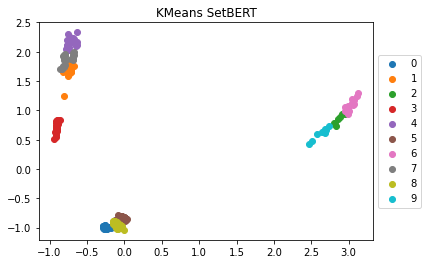

In [42]:
for i in unique_labels:
    plt.scatter(points[labels == i, 0], points[labels == i, 1], label = i)
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5))
plt.title("KMeans SetBERT")

In [43]:
unique_labels = np.unique(chamfer_labels)

Text(0.5, 1.0, 'KMeans Chamfer')

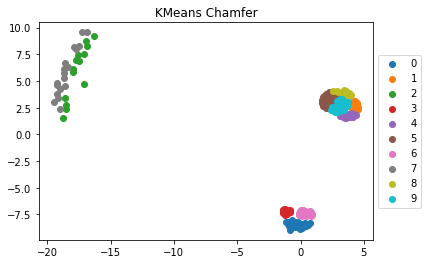

In [44]:
for i in unique_labels:
    plt.scatter(chamfer_points[chamfer_labels == i, 0], chamfer_points[chamfer_labels == i, 1], label = i)
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5))
plt.title("KMeans Chamfer")

In [45]:
from sklearn.metrics import normalized_mutual_info_score

In [46]:
normalized_mutual_info_score(np.repeat(np.arange(len(seq_gen_collection)), 32), labels)

0.7997085713409823

In [47]:
normalized_mutual_info_score(np.repeat(np.arange(len(seq_gen_collection)), 32), chamfer_labels)

0.9027823666173309